In [1]:
# Preamble (system)
import sys
import os

if sys.version_info[0] < 3:
  raise AssertionError('Please run this notebook with Python 3.')

In [2]:
# Preamble (EMTF)
import numpy as np

from emtf_algos import *
from emtf_nbtools import *

# Preamble (notebook)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import collections
import functools
import itertools
import toolz

In [3]:
# Preamble (ML)
np.random.seed(2027)  # set random seed

import tensorflow as tf
tf.random.set_seed(2027)  # set random seed

#import numba
#from numba import njit, vectorize
#import dask
#import dask.array as da

try:
  import emtf_nnet
except:
  raise ImportError('This notebook requires emtf_nnet. It can be found at '
                    'https://github.com/jiafulow/emtf-nnet')

logger = get_logger()
logger.info('Using cmssw      : {}'.format(os.environ.get('CMSSW_VERSION', 'n/a')))
logger.info('Using python     : {}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {}'.format(np.__version__))
logger.info('Using matplotlib : {}'.format(matplotlib.__version__))
logger.info('Using tensorflow : {}'.format(tf.__version__))
logger.info('Using keras      : {}'.format(tf.keras.__version__))
logger.info('.. list devices  : {}'.format(tf.config.list_physical_devices()))
#logger.info('Using numba      : {}'.format(numba.__version__))
#logger.info('Using dask       : {}'.format(dask.__version__))
logger.info('Using emtf-nnet  : {}'.format(emtf_nnet.__version__))

[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using python     : 3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) [GCC 7.3.0]
[INFO    ] Using numpy      : 1.19.5
[INFO    ] Using matplotlib : 3.3.2
[INFO    ] Using tensorflow : 2.4.1
[INFO    ] Using keras      : 2.4.0
[INFO    ] .. list devices  : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[INFO    ] Using emtf-nnet  : 0.0.1


In [4]:
# Preamble (ML additional stuff)
import pandas as pd
import seaborn as sns

#import tensorflow_probability as tfp
#tfb = tfp.bijectors
#tfd = tfp.distributions

#import tensorflow_addons as tfa
#import tensorflow_model_optimization as tfmot

In [5]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(0,-1,-2)
timezone = 0

# quantized NN: True/False
do_quantization = True

#maxevents = 50
maxevents = -1

workers = 1
#workers = 8

# Input files
features_fname = 'features.h5'


## Scheduler
#dask.config.set(scheduler='threads', num_workers=workers)

# Styling
plt.style.use('tdrstyle.mplstyle')
cm = get_colormap()

logger.info('Processing zone {} timezone {}'.format(zone, timezone))
logger.info('.. maxevents        : {}'.format(maxevents))
logger.info('.. workers          : {}'.format(workers))

[INFO    ] Processing zone 0 timezone 0
[INFO    ] .. maxevents        : -1
[INFO    ] .. workers          : 1


### Load data

In [6]:
import h5py
file_handles = []

def load_features():
  fname = features_fname
  logger.info('Loading from {}'.format(fname))
  loaded = h5py.File(fname, 'r')
  file_handles.append(loaded)

  features = np.array(loaded['features'])
  truths = np.array(loaded['truths'])
  logger.info('features: {} dtype: {}'.format(features.shape, features.dtype))
  logger.info('truths: {} dtype: {}'.format(truths.shape, truths.dtype))
  return (features, truths)

In [7]:
# Load features and truths
features, truths = load_features()

# Close the files
for file_handle in file_handles:
  file_handle.close()

[INFO    ] Loading from features.h5
[INFO    ] features: (1605694, 40) dtype: int32
[INFO    ] truths: (1605694, 9) dtype: float32


In [8]:
from emtf_nnet.architecture import endless_nnet_v3

# Split into train/test
x_train, x_test, y_train, y_test = endless_nnet_v3.get_x_y_data(
    features, truths, batch_size=8192, mask_value=ma_fill_value())
logger.info('x_train: {} y_train: {} x_test: {} y_test: {}'.format(
    x_train.shape, y_train.shape, x_test.shape, y_test.shape))

[INFO    ] x_train: (1212416, 40) y_train: (1212416, 1) x_test: (393278, 40) y_test: (393278, 1)


### Create model

In [9]:
# Set hyperparameters
learning_rate = 0.005
final_learning_rate = learning_rate * 0.02
gradient_clipnorm = 10.
epochs = 30 + 120
batch_size = 2048

num_train_samples = x_train.shape[0]
callbacks = [emtf_nnet.keras.callbacks.LearningRateLogger(),]
logger.info('learning_rate: {} final_learning_rate: {} epochs: {} batch_size: {}'.format(
    learning_rate, final_learning_rate, epochs, batch_size))

# Create model
preprocessing_layer = endless_nnet_v3.create_preprocessing_layer(x_train)
lr_schedule = endless_nnet_v3.create_lr_schedule(
    num_train_samples, epochs=epochs, batch_size=batch_size,
    learning_rate=learning_rate, final_learning_rate=final_learning_rate)
optimizer = endless_nnet_v3.create_optimizer(
    lr_schedule, gradient_clipnorm=gradient_clipnorm)
model = endless_nnet_v3.create_model(
    preprocessing_layer=preprocessing_layer, optimizer=optimizer)
model.summary()

[INFO    ] learning_rate: 0.005 final_learning_rate: 0.0001 epochs: 150 batch_size: 2048


Model: "nnet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing (FeatureNormal (None, 40)                80        
_________________________________________________________________
dense (MutatedDense)         (None, 24)                960       
_________________________________________________________________
batch_normalization (Mutated (None, 24)                96        
_________________________________________________________________
activation (TanhActivation)  (None, 24)                0         
_________________________________________________________________
dense_1 (MutatedDense)       (None, 24)                576       
_________________________________________________________________
batch_normalization_1 (Mutat (None, 24)                96        
_________________________________________________________________
activation_1 (TanhActivation (None, 24)                0

### Train model

In [10]:
# Training utils
class HistoryPlotter(object):
  def __init__(self, history, metric=None):
    self.history = history
    if metric is None:
      metric = 'loss'
    self.metric = metric

  def plot(self):
    train_value = self.history.history[self.metric]
    val_value = self.history.history['val_' + self.metric]
    lr_value = self.history.history['lr']
    maxnorm_value = self.history.history['gradient_maxnorm']
    tup = (len(self.history.epoch), len(self.history.epoch), self.metric,
           train_value[-1], 'val_' + self.metric, val_value[-1])
    logger.info('Epoch {}/{} - {}: {:.4f} - {}: {:.4f}'.format(*tup))

    fig, axs = plt.subplots(1, 2, figsize=(6, 6/2), tight_layout=True)
    ax = axs[0]
    ax.plot(self.history.epoch, lr_value, color='C0')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Learning rate')
    ax.grid(True)
    ax = axs[1]
    ax.plot(self.history.epoch, train_value, color='C0', label='Train')
    ax.plot(self.history.epoch, val_value, '--', color='C0', label='Val')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(self.metric.replace('_', ' ').title())
    ax.set_ylim(0, 1.5)
    ax.legend(loc='upper right')
    ax.grid(True)
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(6, 6/2), tight_layout=True)
    ax = axs[0]
    ax.plot(self.history.epoch, maxnorm_value, color='C0')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Gradient maxnorm')
    ax.set_ylim(0, 1.5)
    ax.grid(True)
    plt.show()


class ModelTrainer(object):
  def __init__(self, model, log_dir='keras_logs', prefix='', suffix='.log'):
    self.model = model
    self.log_dir = log_dir
    self.prefix = prefix
    self.suffix = suffix

  def fit(self, *args, **kwargs):
    from contextlib import redirect_stdout
    from datetime import datetime
    import os
    import tempfile
    if not os.path.exists(self.log_dir):
      os.makedirs(self.log_dir)
    fd, name = tempfile.mkstemp(prefix=self.prefix, suffix=self.suffix, dir=self.log_dir, text=True)

    start_time = datetime.now()
    logger.info('Begin training ...')

    # Fit
    with os.fdopen(fd, 'w') as f:
      with redirect_stdout(f):
        history = self.model.fit(*args, **kwargs)
    logger.info('Done training. Time elapsed: {}'.format(str(datetime.now() - start_time)))

    # Plot history
    HistoryPlotter(history).plot()
    return history

[INFO    ] Begin training ...
[INFO    ] Done training. Time elapsed: 0:05:45.999310
[INFO    ] Epoch 150/150 - loss: 0.0775 - val_loss: 0.0773


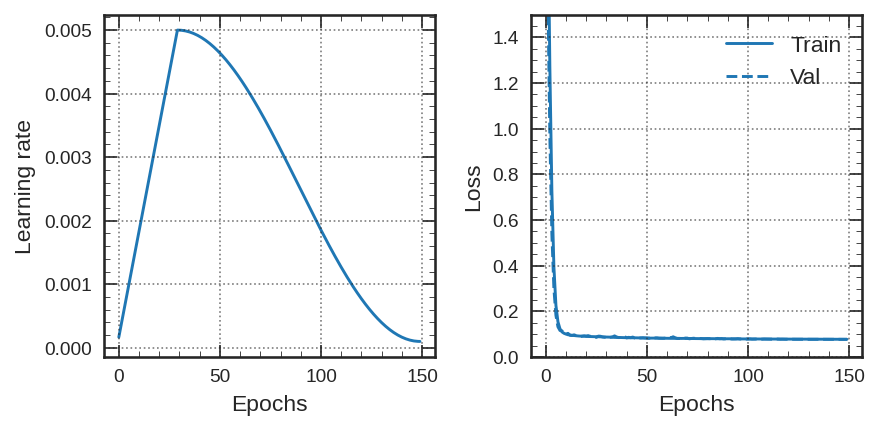

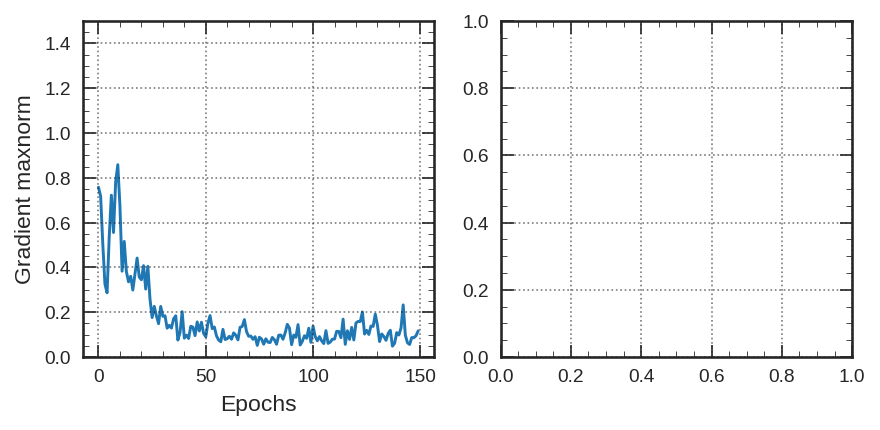

[INFO    ] Saved as nnet_model.h5


In [11]:
# Train model
history = ModelTrainer(model).fit(
    x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,
    validation_data=(x_test, y_test), shuffle=True)
emtf_nnet.keras.utils.save_nnet_model(model)
logger.info('Saved as {}'.format(model.name + '.h5'))

### Quantization

In [12]:
# Create quantized model
if do_quantization:
  # Set warmup_steps to zero
  lr_schedule.decay_steps += lr_schedule.warmup_steps
  lr_schedule.warmup_steps = 0

  # Quantize model
  base_model = model
  optimizer = endless_nnet_v3.create_optimizer(
      lr_schedule, gradient_clipnorm=gradient_clipnorm)
  model = endless_nnet_v3.create_quant_model(
      base_model, optimizer=optimizer)
  model.summary()

Model: "quant_nnet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quant_preprocessing (Quantiz (None, 40)                83        
_________________________________________________________________
quant_dense (QuantizeWrapper (None, 24)                1061      
_________________________________________________________________
quant_activation (QuantizeWr (None, 24)                3         
_________________________________________________________________
quant_dense_1 (QuantizeWrapp (None, 24)                677       
_________________________________________________________________
quant_activation_1 (Quantize (None, 24)                3         
_________________________________________________________________
quant_dense_2 (QuantizeWrapp (None, 16)                453       
_________________________________________________________________
quant_activation_2 (Quantize (None, 16)           

[INFO    ] Begin training ...
[INFO    ] Done training. Time elapsed: 0:08:30.095277
[INFO    ] Epoch 150/150 - loss: 0.0758 - val_loss: 0.0775


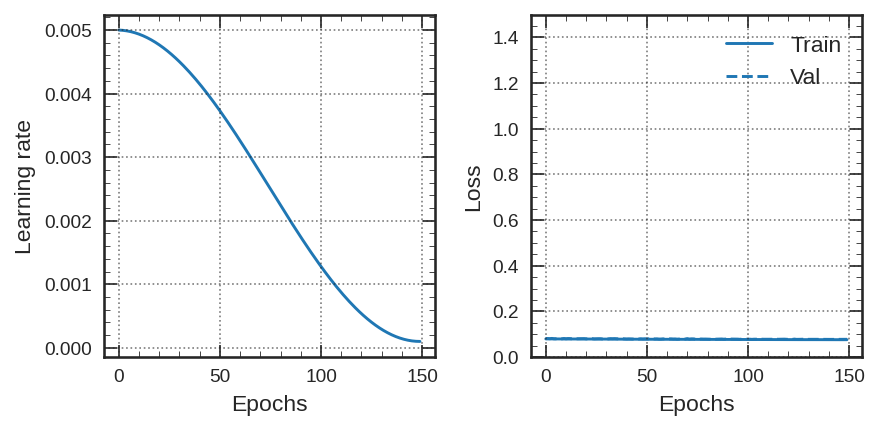

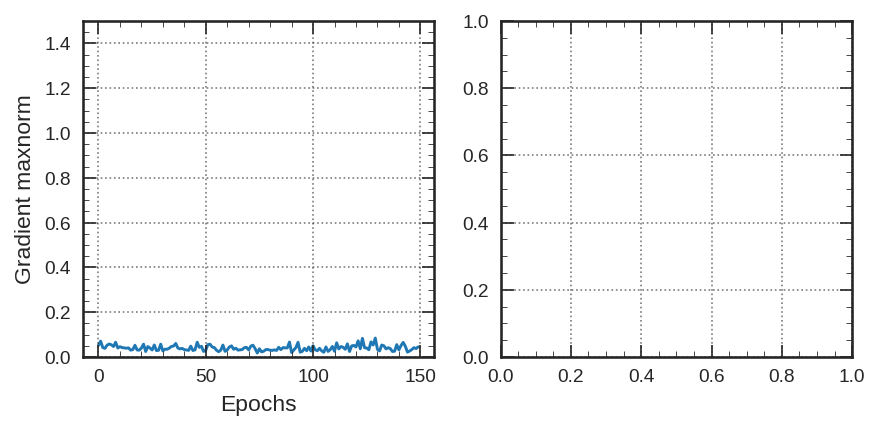

[INFO    ] Saved as quant_nnet_model.h5


In [13]:
# Train quantized model
if do_quantization:
  history = ModelTrainer(model).fit(
      x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,
      validation_data=(x_test, y_test), shuffle=True)
  emtf_nnet.keras.utils.save_nnet_model(model)
  logger.info('Saved as {}'.format(model.name + '.h5'))

### Evaluate model

In [14]:
# Evaluation utils
from scipy.optimize import curve_fit

def gaus(x, a, mu, sig):
  return a * np.exp(-0.5 * np.square((x - mu) / sig))

def fit_gaus(hist, edges, mu=0.0, sig=1.0):
  hist = hist.astype(np.float64)
  edges = edges.astype(np.float64)
  xdata = (edges[1:] + edges[:-1]) / 2
  ydata = hist
  popt, pcov = curve_fit(gaus, xdata, ydata, p0=[np.max(hist), mu, sig])
  if not np.isfinite(pcov).all():
    raise RuntimeError("Fit has failed to converge.")
  popt[2] = np.abs(popt[2])  # take absolute value of sigma
  return popt

def mean_squared_error(y_true, y_pred):
  # K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
  return tf.keras.losses.mean_squared_error(y_true, y_pred).numpy()

def mean_absolute_error(y_true, y_pred):
  # K.mean(math_ops.abs(y_pred - y_true), axis=-1)
  return tf.keras.losses.mean_absolute_error(y_true, y_pred).numpy()

def median_absolute_deviation(y_true, y_pred):
  scale = 0.6744897501960817  # special.ndtri(0.75)
  return np.median(np.abs(y_pred - y_true), axis=-1) / scale

In [15]:
# Make predictions
y_test_true = y_test.copy()
y_test_pred = model.predict(x_test, batch_size=8192)

# Subsets of x_test, y_test_true, y_test_pred
num_test_samples = 10000
index_array = np.arange(x_test.shape[0])
shuffle = True
if shuffle:
  np.random.shuffle(index_array)

x_test_1 = x_test[index_array[:num_test_samples]]
y_test_true_1 = y_test_true[index_array[:num_test_samples]]
y_test_pred_1 = y_test_pred[index_array[:num_test_samples]]

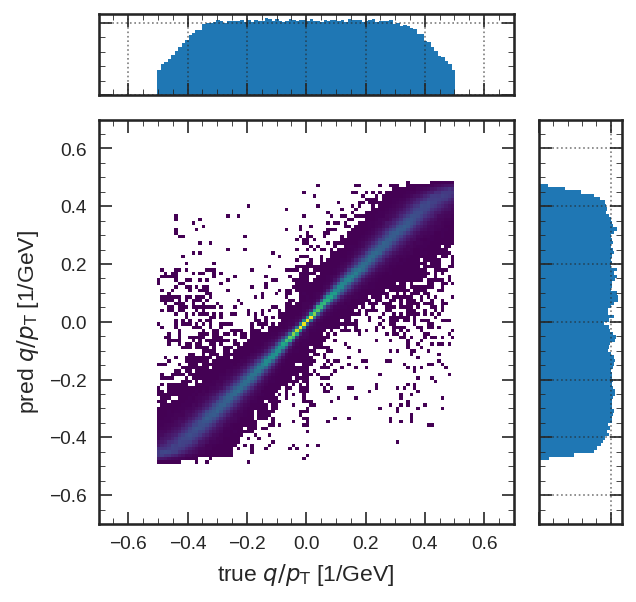

In [16]:
# Plot predictions
fig = plt.figure(figsize=(4.5,4.5))

xx = y_test_true
yy = y_test_pred

gs = plt.GridSpec(2, 2, width_ratios=(5,1), height_ratios=(1,5), hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[1,0])
ax_top = fig.add_subplot(gs[0,0], sharex=ax)
ax_right = fig.add_subplot(gs[1,1], sharey=ax)

ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(120,120), range=((-0.7,0.7),(-0.7,0.7)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $q/p_{\mathrm{T}}$ [1/GeV]')
ax_top.hist(np.squeeze(xx), bins=120, range=(-0.7,0.7))
ax_top.tick_params(labelbottom=False, labelleft=False)
ax_right.hist(np.squeeze(yy), bins=120, range=(-0.7,0.7), orientation='horizontal')
ax_right.tick_params(labelbottom=False, labelleft=False)

plt.show()

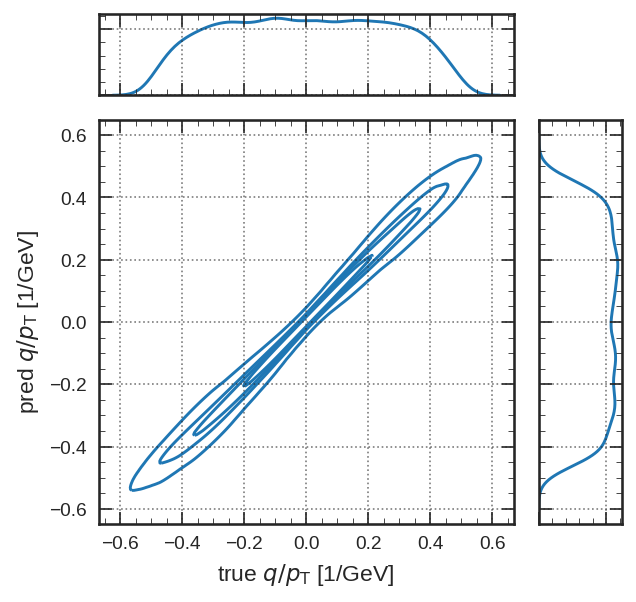

In [17]:
# Plot predictions
fig = plt.figure(figsize=(4.5,4.5))

xx = y_test_true_1
yy = y_test_pred_1

gs = plt.GridSpec(2, 2, width_ratios=(5,1), height_ratios=(1,5), hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[1,0])
ax_top = fig.add_subplot(gs[0,0], sharex=ax)
ax_right = fig.add_subplot(gs[1,1], sharey=ax)

df = pd.DataFrame({'x': np.squeeze(xx), 'y': np.squeeze(yy)})
sns.kdeplot(data=df, x='x', y='y', levels=5, bw_adjust=1, ax=ax)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $q/p_{\mathrm{T}}$ [1/GeV]')
sns.kdeplot(data=df, x='x', bw_adjust=1, ax=ax_top)
ax_top.set_xlabel('')
ax_top.set_ylabel('')
ax_top.tick_params(labelbottom=False, labelleft=False)
sns.kdeplot(data=df, y='y', bw_adjust=1, ax=ax_right)
ax_right.set_xlabel('')
ax_right.set_ylabel('')
ax_right.tick_params(labelbottom=False, labelleft=False)

plt.show()

[INFO    ] (mu, sig, mse, mae, mad): -1.2800e-03, 0.0344, 0.0014, 0.0245, 0.0363
[INFO    ] gaus fit (a, mu, sig): 31041.49, -5.7814e-04, 0.0230
[INFO    ] (mu, sig, mse, mae, mad): 5.5404e-04, 0.0152, 0.0005, 0.0115, 0.0110
[INFO    ] gaus fit (a, mu, sig): 3823.60, 7.0021e-04, 0.0102


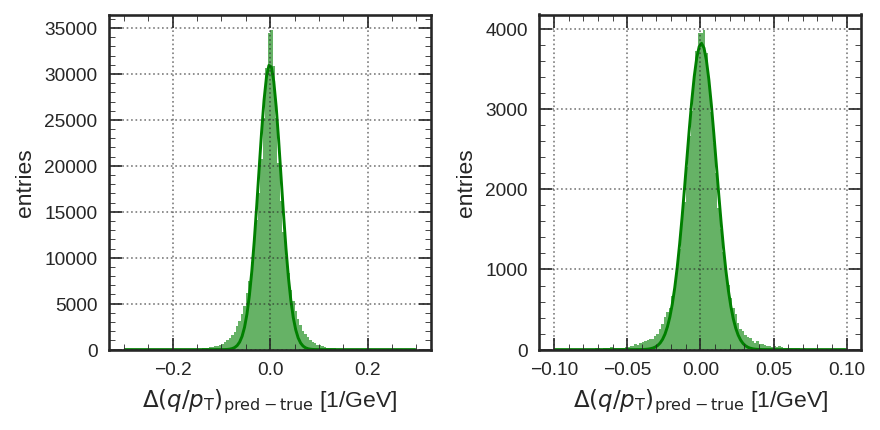

In [18]:
# Plot Delta(q/pt)
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = y_test_true
yb = y_test_pred
yy = yb - ya
yy_core = yy[np.abs(yy)<0.3]

ax = axs[0]
hist, edges, _ = ax.hist(yy, bins=120, range=(-0.3,0.3), histtype='stepfilled', facecolor='g', alpha=0.6)
metrics = yy_core.mean(), yy_core.std(), mean_squared_error(ya, yb).mean(), mean_absolute_error(ya, yb).mean(), median_absolute_deviation(ya, yb).mean()
popt = fit_gaus(hist, edges, mu=metrics[0], sig=metrics[1])
xdata = (edges[1:] + edges[:-1])/2
ax.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')
logger.info('(mu, sig, mse, mae, mad): {0:.4e}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}'.format(*metrics))
logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

# Repeat with pt > 14 GeV
sel = (np.abs(1.0/y_test_true)>14.)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]
yy_core = yy[np.abs(yy)<0.3/3]

ax = axs[1]
hist, edges, _ = ax.hist(yy, bins=120, range=(-0.3/3,0.3/3), histtype='stepfilled', facecolor='g', alpha=0.6)
metrics = yy_core.mean(), yy_core.std(), mean_squared_error(ya, yb).mean(), mean_absolute_error(ya, yb).mean(), median_absolute_deviation(ya, yb).mean()
popt = fit_gaus(hist, edges, mu=metrics[0], sig=metrics[1])
xdata = (edges[1:] + edges[:-1])/2
ax.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')
logger.info('(mu, sig, mse, mae, mad): {0:.4e}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}'.format(*metrics))
logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

plt.show()

/blue/avery/jlow/L1MuonTrigger/scratch/2020-00-00-work/miniconda/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
[INFO    ] (mu, sig, mse, mae, mad): -7.3957e-04, 0.2131, inf, inf, inf
[INFO    ] gaus fit (a, mu, sig): 28098.19, -1.2858e-02, 0.1266
[INFO    ] (mu, sig, mse, mae, mad): -6.3660e-02, 0.3827, inf, inf, 0.3258
[INFO    ] gaus fit (a, mu, sig): 2321.89, -1.1487e-01, 0.2238


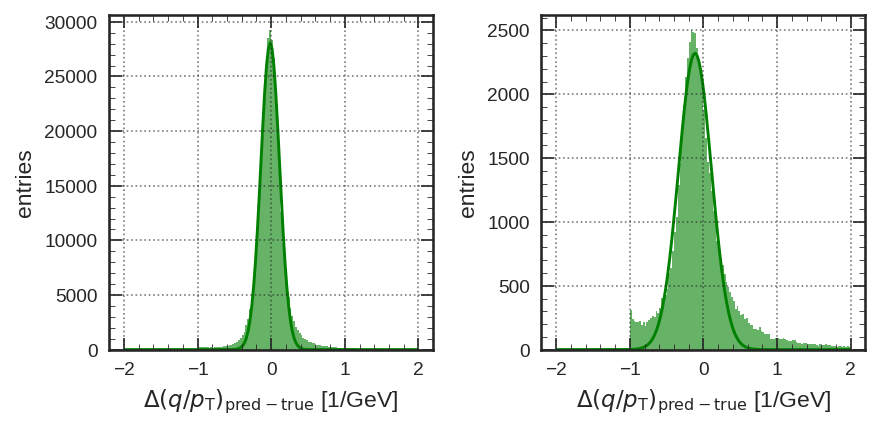

In [19]:
# Plot Delta(q/pt) / pt
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = np.abs(y_test_true/y_test_true)
yb = np.abs(y_test_true/y_test_pred)
yy = yb - ya
yy_core = yy[np.abs(yy)<1.5]

ax = axs[0]
hist, edges, _ = ax.hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
metrics = yy_core.mean(), yy_core.std(), mean_squared_error(ya, yb).mean(), mean_absolute_error(ya, yb).mean(), median_absolute_deviation(ya, yb).mean()
popt = fit_gaus(hist, edges, mu=metrics[0], sig=metrics[1])
xdata = (edges[1:] + edges[:-1])/2
ax.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')
logger.info('(mu, sig, mse, mae, mad): {0:.4e}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}'.format(*metrics))
logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

# Repeat with pt > 14 GeV
sel = (np.abs(1.0/y_test_true)>14.)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]
yy_core = yy[np.abs(yy)<1.5]

ax = axs[1]
hist, edges, _ = ax.hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
metrics = yy_core.mean(), yy_core.std(), mean_squared_error(ya, yb).mean(), mean_absolute_error(ya, yb).mean(), median_absolute_deviation(ya, yb).mean()
popt = fit_gaus(hist, edges, mu=metrics[0], sig=metrics[1])
xdata = (edges[1:] + edges[:-1])/2
ax.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')
logger.info('(mu, sig, mse, mae, mad): {0:.4e}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}'.format(*metrics))
logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

plt.show()

/blue/avery/jlow/L1MuonTrigger/scratch/2020-00-00-work/miniconda/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


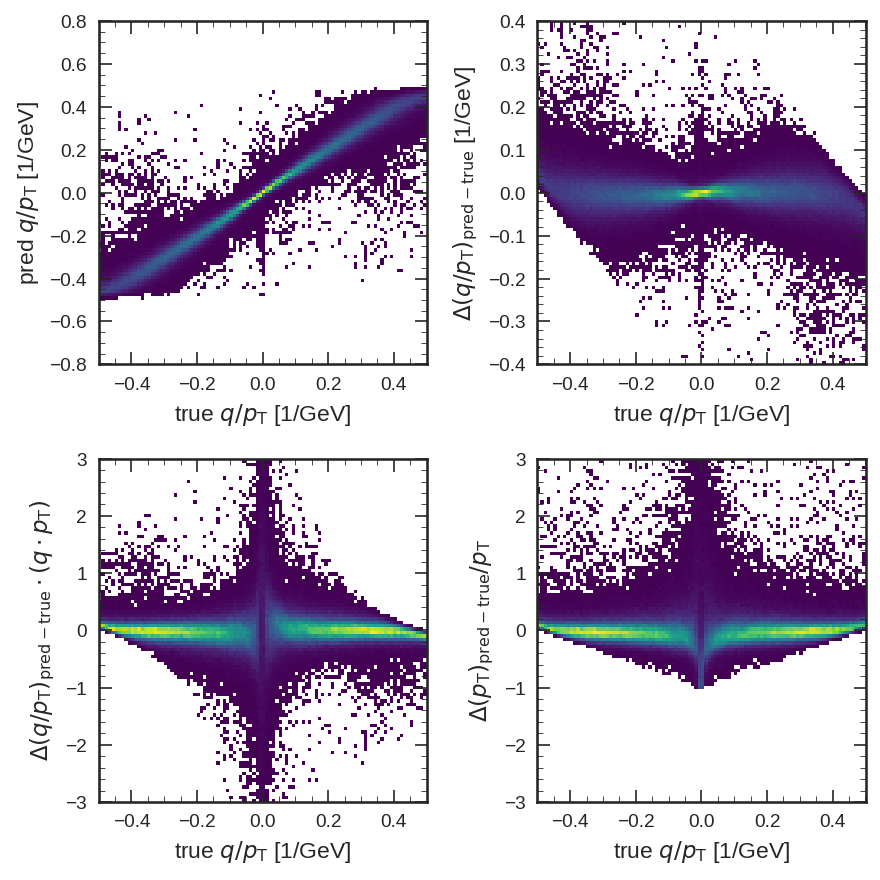

In [20]:
# Plot correlations
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

xx = y_test_true
yy = y_test_pred
ax = axs[0,0]
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.8,0.8)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $q/p_{\mathrm{T}}$ [1/GeV]')

yy = y_test_pred - y_test_true
ax = axs[0,1]
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.4,0.4)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')

yy = (y_test_pred - y_test_true)/np.abs(y_test_true)
ax = axs[1,0]
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}} \cdot (q \cdot p_{\mathrm{T}})$')

yy = np.abs(y_test_true/y_test_pred) - 1
ax = axs[1,1]
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{pred-true}} / p_{\mathrm{T}}$')

plt.show()

In [21]:
# Make better resolution plot
# resolution defined as Delta(pt) over pt (no charge), binned in 1/pt (also no charge)
xx = np.abs(y_test_true)
yy = np.abs(y_test_true/y_test_pred) - 1
xx = np.squeeze(xx)
yy = np.squeeze(yy)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xx_pt = np.zeros(nbinsx, dtype=np.float32)
yy_mu = np.zeros(nbinsx, dtype=np.float32)
yy_sig = np.zeros(nbinsx, dtype=np.float32)
yy_tail = np.zeros(nbinsx, dtype=np.float32)
yy_cov = np.zeros(nbinsx, dtype=np.float32)

cache = {}

for i in range(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue

  pt = xx_i.mean()
  pt = 1.0 / pt

  yy_i = yy[inds==i]
  yy_i = yy_i[(-1.0 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = yy_i.mean(), yy_i.std()
  assert np.abs(mu) < 1.0
  assert np.abs(sig) < 2.0

  hist, edges = np.histogram(yy_i, bins=160, range=(-2,2))
  xdata = (edges[1:] + edges[:-1])/2
  try:
    popt = fit_gaus(hist, edges, mu=mu, sig=sig)
  except:
    popt = np.array([np.nan, np.nan, np.nan])
  #print(i, len(xx_i), mu, sig, pt, popt)

  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  tail = hist - ydata        # check non-gaussian high tail
  tail[tail < 0] = 0         # ignore hist < gaus
  tail[xdata < popt[2]] = 0  # ignore low tail
  tail = tail.sum() / len(xx_i)

  pct = np.percentile(yy_i, (100 - 90), overwrite_input=True)  # find 10-percentile
  cov = -1 * pct / popt[2]
  # If truly gaussian, the required number of sigmas is 1.28155 for 90% coverage
  #print(scipy.special.erfinv(0.80) * np.sqrt(2))

  xx_pt[i] = pt
  yy_mu[i] = popt[1]
  yy_sig[i] = popt[2]
  yy_tail[i] = tail
  yy_cov[i] = cov

  if 14. < pt < 15.:
    cache[0] = (i, xx_i, yy_i)
  elif 20. < pt < 22.:
    cache[1] = (i, xx_i, yy_i)
  elif 25. < pt < 28.:
    cache[2] = (i, xx_i, yy_i)
  elif 28. < pt < 33.:
    cache[3] = (i, xx_i, yy_i)

/blue/avery/jlow/L1MuonTrigger/scratch/2020-00-00-work/miniconda/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


[INFO    ] gaus fit (a, mu, sig): 244.75, -6.9782e-02, 0.1671
[INFO    ] gaus fit (a, mu, sig): 228.17, -1.0471e-01, 0.1729
[INFO    ] gaus fit (a, mu, sig): 190.96, -1.1846e-01, 0.2024
[INFO    ] gaus fit (a, mu, sig): 176.84, -1.2757e-01, 0.2137


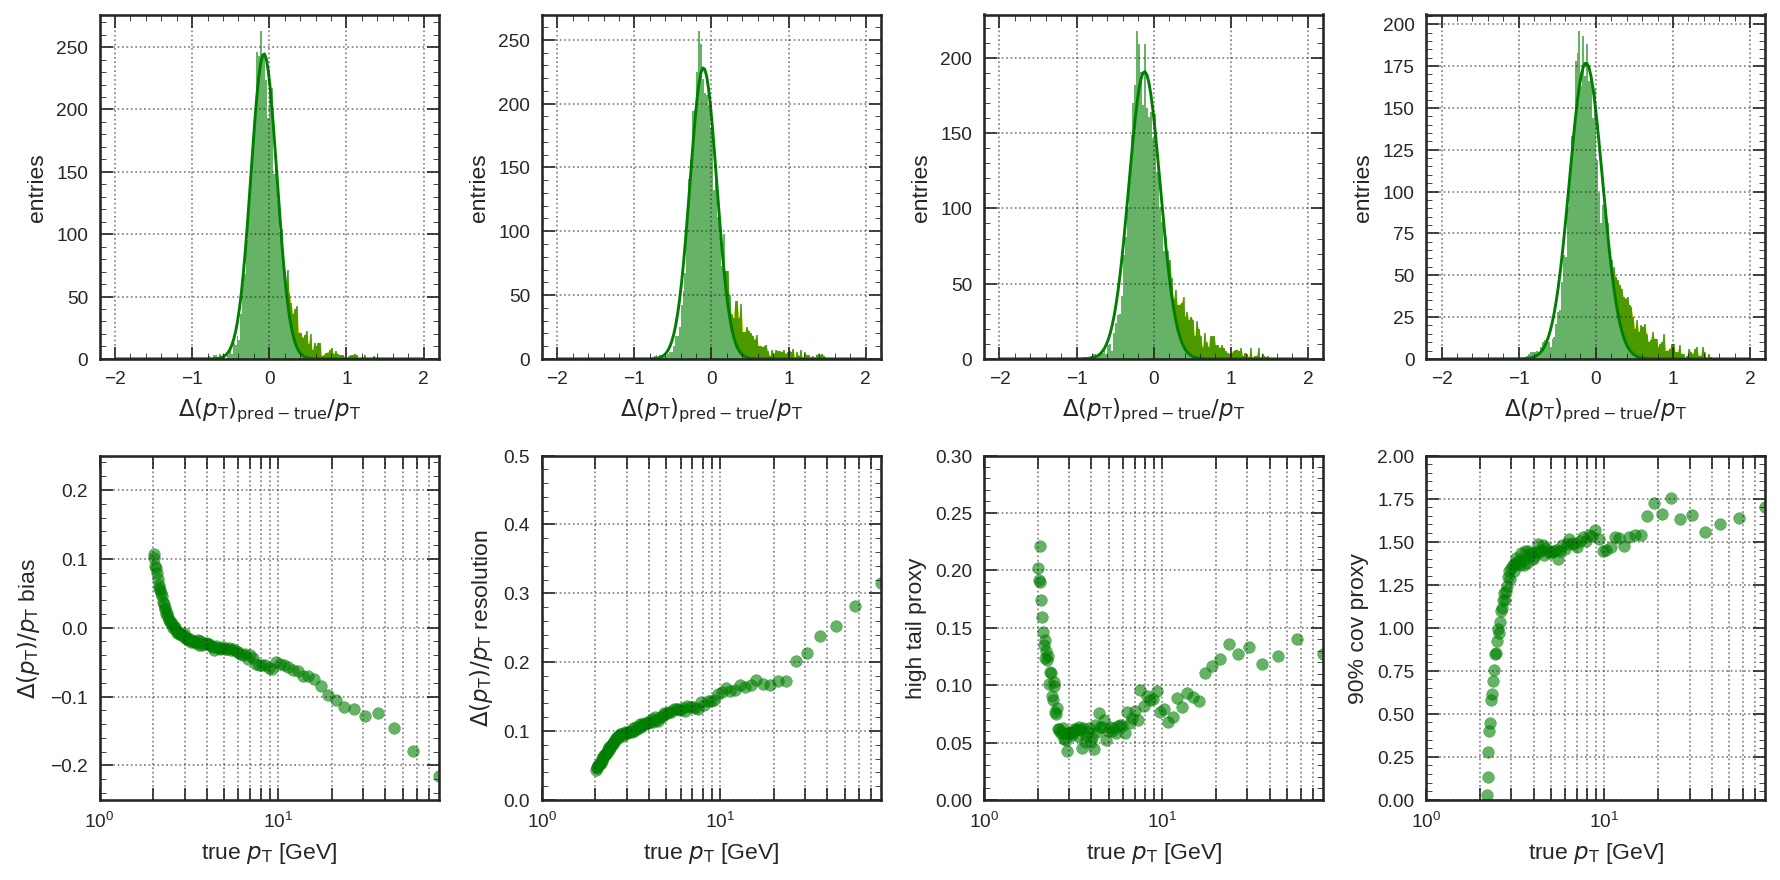

In [22]:
# Make better resolution plot
fig, axs = plt.subplots(2, 4, figsize=(6*2,6), tight_layout=True)

for i in range(4):
  ax = axs[0,i]
  (ii, xx_i, yy_i) = cache[i]  # read from cache
  hist, edges, _ = ax.hist(yy_i, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
  popt = fit_gaus(hist, edges, mu=yy_mu[ii], sig=yy_mu[ii])
  xdata = (edges[1:] + edges[:-1])/2
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  tail = hist - ydata        # check non-gaussian high tail
  tail[tail < 0] = 0         # ignore hist < gaus
  tail[xdata < popt[2]] = 0  # ignore low tail
  ax.plot(xdata, ydata, color='g')
  ax.fill_between(xdata, ydata, ydata + tail, facecolor='y')
  ax.set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{pred-true}} / p_{\mathrm{T}}$')
  ax.set_ylabel(r'entries')
  logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

cache.clear()  # clear cache

ax = axs[1,0]
ax.scatter(xx_pt, yy_mu, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(-0.25,0.25)
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ bias')

ax = axs[1,1]
ax.scatter(xx_pt, yy_sig, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.5)
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ resolution')

ax = axs[1,2]
ax.scatter(xx_pt, yy_tail, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.3)
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'high tail proxy')

ax = axs[1,3]
ax.scatter(xx_pt, yy_cov, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,2)
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'90% cov proxy')

plt.show()

In [23]:
# Make ridgeplot
def min_max(x):
  return (np.min(x), np.max(x))

def ridgeplot():
  n = xx.shape[1]
  fig, axs = plt.subplots(n, 1, figsize=(6,n*0.25), sharex=True, sharey=False, gridspec_kw=dict(hspace=-0.5))
  pal = sns.cubehelix_palette(n, rot=-.4, light=.7)

  for i in range(n):
    if n == 1:
      ax = axs
    else:
      ax = axs[(n - 1) - i]
    limit = 4
    sns.kdeplot(np.clip(xx[:, i], -limit, limit), bw_adjust=0.25, clip_on=False, fill=True, alpha=1, color=pal[i], ax=ax)
    sns.kdeplot(np.clip(xx[:, i], -limit, limit), bw_adjust=0.25, clip_on=False, lw=1.0, color='w', ax=ax)

    # Remove borders, axis ticks, labels, and make background transparent
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                   labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    if i == 0:
      ax.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
    spines = ['top', 'right', 'left', 'bottom']
    for s in spines:
      if s != 'bottom':
        ax.spines[s].set_visible(False)
    ax.patch.set_alpha(0)

    # Label
    ax.text(0, 0.2, str(i), fontsize=8, ha='right', va='center', transform=ax.transAxes)

  logger.info('(min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  plt.show()

In [24]:
# Inspect intermediate layers
if not do_quantization:
  extractor_layers = [model.get_layer('preprocessing').output,
                      model.get_layer('dense').output,
                      model.get_layer('batch_normalization').output,
                      model.get_layer('activation').output,
                      model.get_layer('dense_1').output,
                      model.get_layer('batch_normalization_1').output,
                      model.get_layer('activation_1').output,
                      model.get_layer('dense_2').output,
                      model.get_layer('batch_normalization_2').output,
                      model.get_layer('activation_2').output,
                      model.get_layer('dense_final').output,]

  extractor = tf.keras.Model(inputs=model.inputs, outputs=extractor_layers)

  extracted = extractor(x_test_1)
  extracted = iter(extracted)
  extracted_preprocessing = next(extracted).numpy()
  extracted_dense = next(extracted).numpy()
  extracted_batch_normalization = next(extracted).numpy()
  extracted_activation = next(extracted).numpy()
  extracted_dense_1 = next(extracted).numpy()
  extracted_batch_normalization_1 = next(extracted).numpy()
  extracted_activation_1 = next(extracted).numpy()
  extracted_dense_2 = next(extracted).numpy()
  extracted_batch_normalization_2 = next(extracted).numpy()
  extracted_activation_2 = next(extracted).numpy()
  extracted_dense_final = next(extracted).numpy()

In [25]:
if not do_quantization:
  xx = extracted_preprocessing
  ridgeplot()
  xx = extracted_batch_normalization
  ridgeplot()
  xx = extracted_activation
  ridgeplot()
  xx = extracted_batch_normalization_1
  ridgeplot()
  xx = extracted_activation_1
  ridgeplot()
  xx = extracted_batch_normalization_2
  ridgeplot()
  xx = extracted_activation_2
  ridgeplot()
  xx = extracted_dense_final
  ridgeplot()

In [26]:
# Inspect model weights
if not do_quantization:
  assert len(model.get_layer('preprocessing').weights) == 2
  assert len(model.get_layer('batch_normalization').weights) == 4
  assert len(model.get_layer('batch_normalization_1').weights) == 4
  assert len(model.get_layer('batch_normalization_2').weights) == 4
  assert len(model.get_layer('dense').weights) == 1
  assert len(model.get_layer('dense_1').weights) == 1
  assert len(model.get_layer('dense_2').weights) == 1
  assert len(model.get_layer('dense_final').weights) == 1

  def get_normalization_scale_and_offset(layer):
    scale = layer.scale.numpy()
    offset = layer.offset.numpy()
    return (scale, offset)

  def get_batchnorm_scale_and_offset(layer):
    scale = (layer.gamma / tf.sqrt(layer.moving_variance)).numpy()
    offset = (layer.beta - layer.moving_mean * (layer.gamma / tf.sqrt(layer.moving_variance))).numpy()
    return (scale, offset)

  def get_folded_kernel_scale_and_offset(kernel, layer):
    scale = (kernel * (layer.gamma / tf.sqrt(layer.moving_variance))).numpy()
    offset = (layer.beta - layer.moving_mean * (layer.gamma / tf.sqrt(layer.moving_variance))).numpy()
    return (scale, offset)

  fig, axs = plt.subplots(3, 4, figsize=(6*2,6/2*3), tight_layout=True)
  pal = sns.cubehelix_palette(12, rot=-.4, light=.7)

  xx = get_normalization_scale_and_offset(model.get_layer('preprocessing'))[0]
  ax = axs[0,0]
  ax.hist(xx, bins=40, color=pal[0])
  logger.info('preprocessing (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('batch_normalization'))[0]
  ax = axs[0,1]
  ax.hist(xx, bins=40, color=pal[1])
  logger.info('batch_normalization (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('batch_normalization_1'))[0]
  ax = axs[0,2]
  ax.hist(xx, bins=40, color=pal[2])
  logger.info('batch_normalization_1 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('batch_normalization_2'))[0]
  ax = axs[0,3]
  ax.hist(xx, bins=40, color=pal[3])
  logger.info('batch_normalization_2 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  xx = get_normalization_scale_and_offset(model.get_layer('preprocessing'))[1]
  ax = axs[1,0]
  ax.hist(xx, bins=40, color=pal[4])
  logger.info('preprocessing (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('batch_normalization'))[1]
  ax = axs[1,1]
  ax.hist(xx, bins=40, color=pal[5])
  logger.info('batch_normalization (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('batch_normalization_1'))[1]
  ax = axs[1,2]
  ax.hist(xx, bins=40, color=pal[6])
  logger.info('batch_normalization_1 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('batch_normalization_2'))[1]
  ax = axs[1,3]
  ax.hist(xx, bins=40, color=pal[7])
  logger.info('batch_normalization_2 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  xx = get_folded_kernel_scale_and_offset(model.get_layer('dense').kernel.numpy(), model.get_layer('batch_normalization'))[0]
  ax = axs[2,0]
  ax.hist(xx.reshape(-1), bins=40, color=pal[8])
  logger.info('dense (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_folded_kernel_scale_and_offset(model.get_layer('dense_1').kernel.numpy(), model.get_layer('batch_normalization_1'))[0]
  ax = axs[2,1]
  ax.hist(xx.reshape(-1), bins=40, color=pal[9])
  logger.info('dense_1 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_folded_kernel_scale_and_offset(model.get_layer('dense_2').kernel.numpy(), model.get_layer('batch_normalization_2'))[0]
  ax = axs[2,2]
  ax.hist(xx.reshape(-1), bins=40, color=pal[10])
  logger.info('dense_2 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = model.get_layer('dense_final').kernel.numpy()
  ax = axs[2,3]
  ax.hist(xx.reshape(-1), bins=40, color=pal[11])
  logger.info('dense_final (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  plt.show()

In [27]:
# Inspect intermediate layers
if do_quantization:
  extractor_layers = [model.get_layer('quant_preprocessing').output,
                      model.get_layer('quant_dense').output,
                      model.get_layer('quant_activation').output,
                      model.get_layer('quant_dense_1').output,
                      model.get_layer('quant_activation_1').output,
                      model.get_layer('quant_dense_2').output,
                      model.get_layer('quant_activation_2').output,
                      model.get_layer('quant_dense_final').output,]

  extractor = tf.keras.Model(inputs=model.inputs, outputs=extractor_layers)

  extracted = extractor(x_test_1)
  extracted = iter(extracted)
  extracted_preprocessing = next(extracted).numpy()
  extracted_dense = next(extracted).numpy()
  extracted_activation = next(extracted).numpy()
  extracted_dense_1 = next(extracted).numpy()
  extracted_activation_1 = next(extracted).numpy()
  extracted_dense_2 = next(extracted).numpy()
  extracted_activation_2 = next(extracted).numpy()
  extracted_dense_final = next(extracted).numpy()

/blue/avery/jlow/L1MuonTrigger/scratch/2020-00-00-work/miniconda/envs/tf/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/blue/avery/jlow/L1MuonTrigger/scratch/2020-00-00-work/miniconda/envs/tf/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
[INFO    ] (min, max): -7.6250, 7.1484


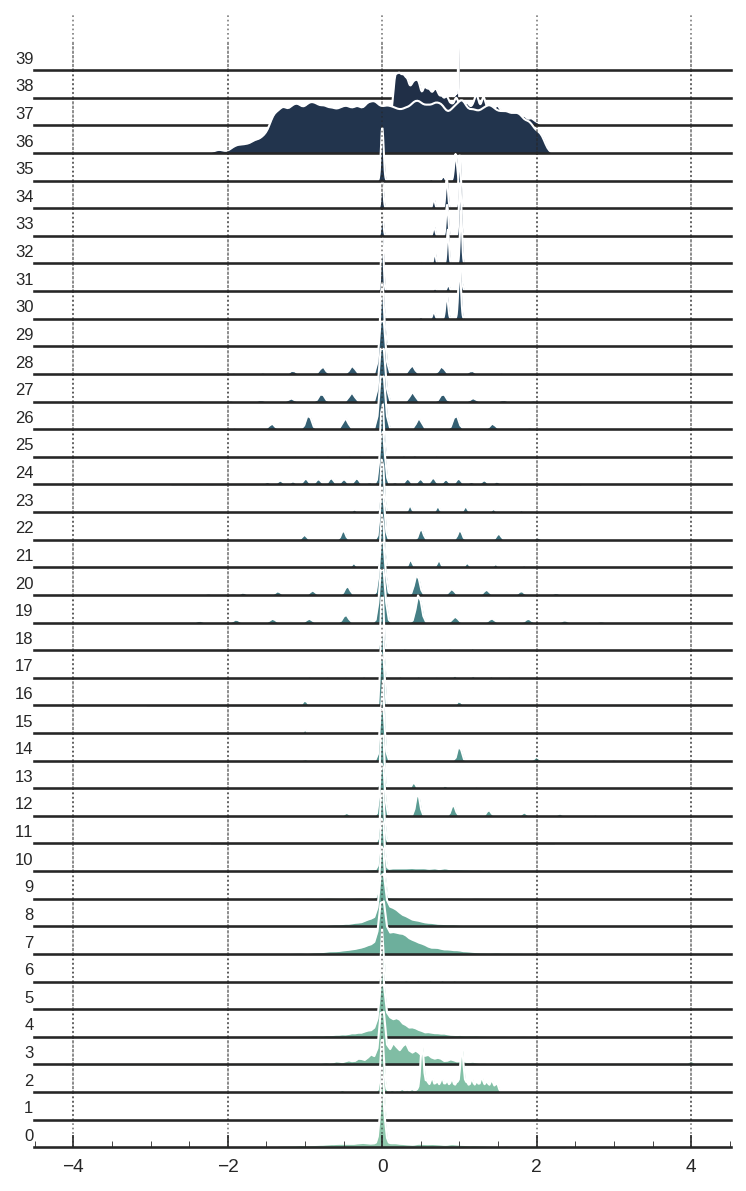

[INFO    ] (min, max): -4.0000, 3.9980


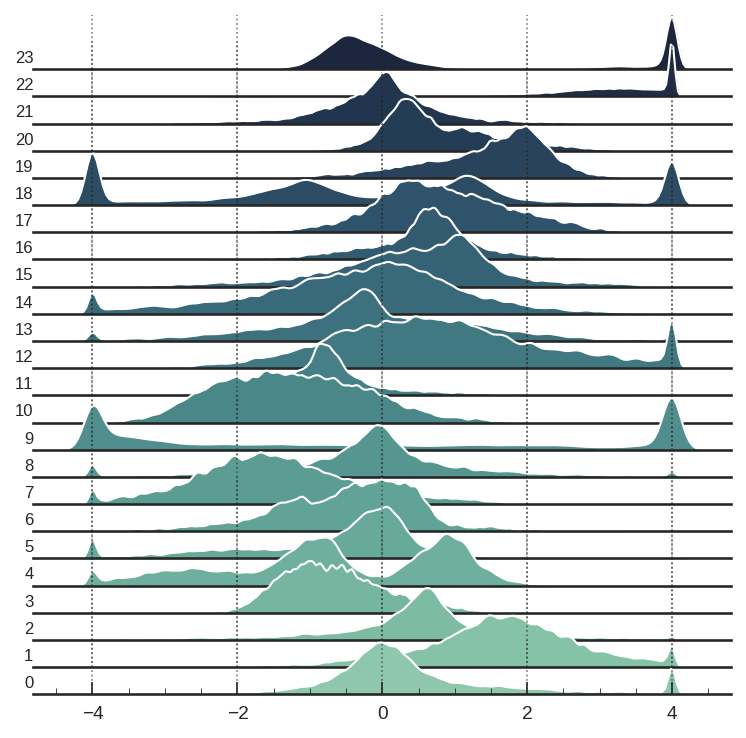

[INFO    ] (min, max): -0.9994, 0.9993


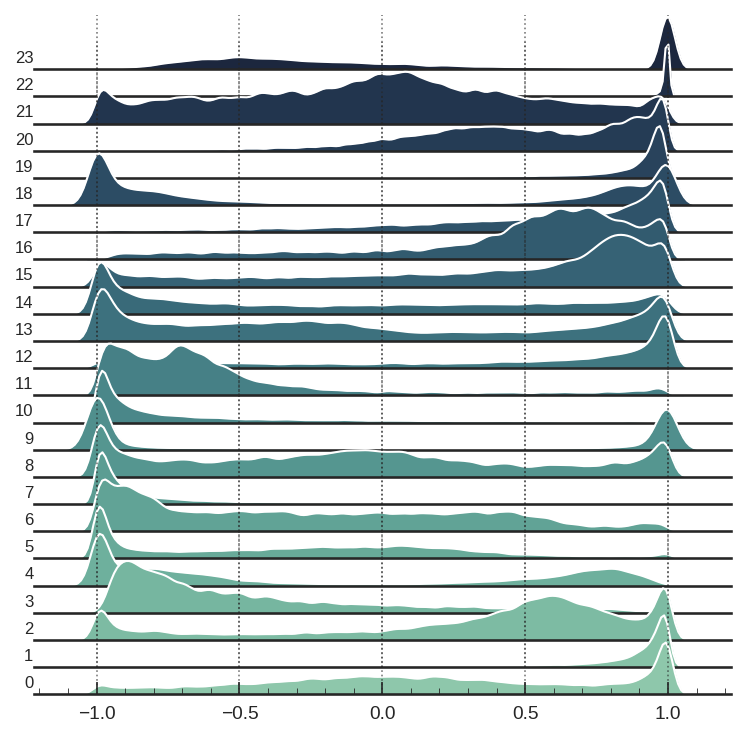

[INFO    ] (min, max): -4.0000, 3.9980


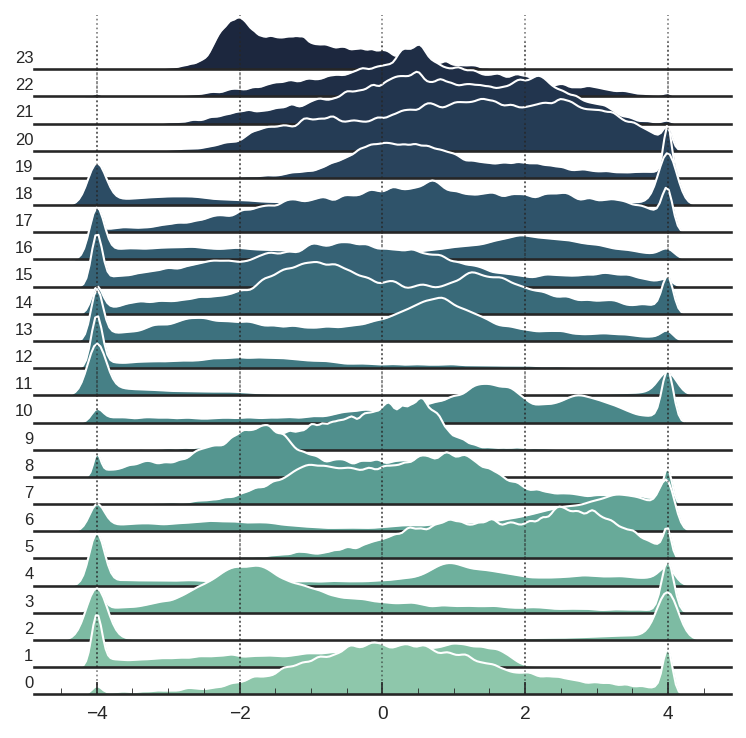

[INFO    ] (min, max): -0.9994, 0.9993


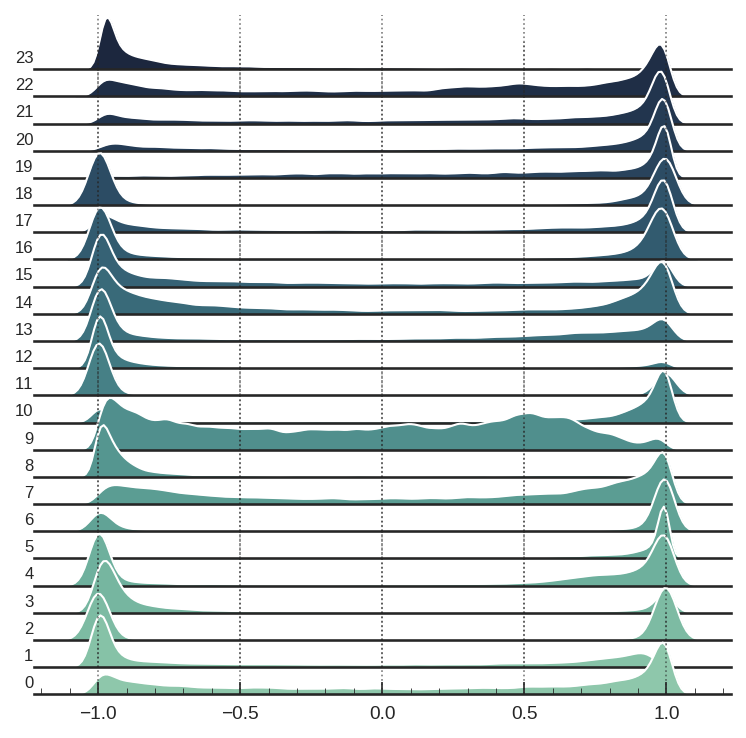

[INFO    ] (min, max): -4.0000, 3.9980


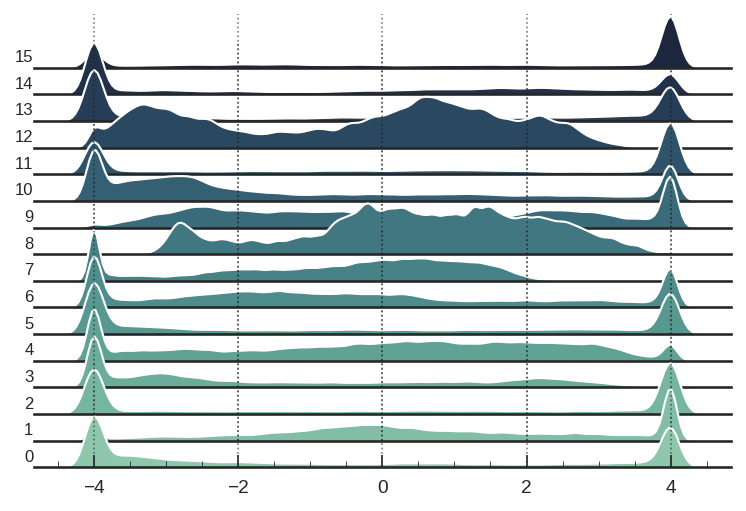

[INFO    ] (min, max): -0.9994, 0.9993


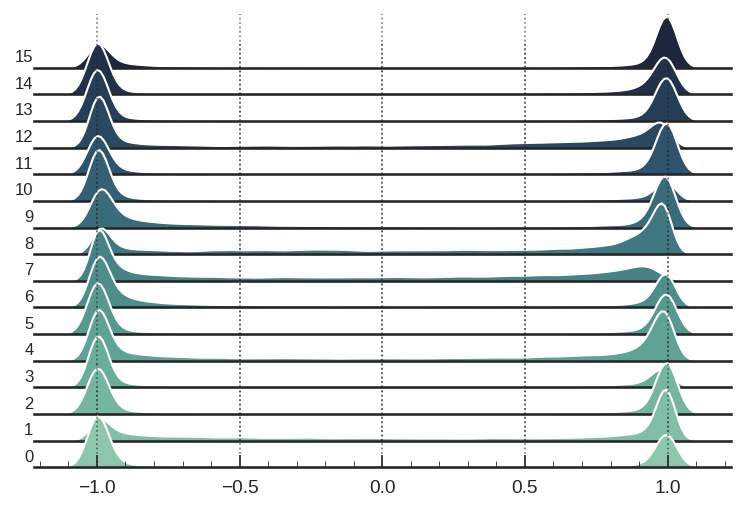

[INFO    ] (min, max): -0.4802, 0.4814


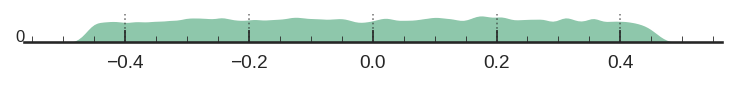

In [28]:
if do_quantization:
  xx = extracted_preprocessing
  ridgeplot()
  xx = extracted_dense
  ridgeplot()
  xx = extracted_activation
  ridgeplot()
  xx = extracted_dense_1
  ridgeplot()
  xx = extracted_activation_1
  ridgeplot()
  xx = extracted_dense_2
  ridgeplot()
  xx = extracted_activation_2
  ridgeplot()
  xx = extracted_dense_final
  ridgeplot()

[INFO    ] preprocessing (min, max): 0.0000, 0.9990
[INFO    ] batch_normalization (min, max): 0.1632, 0.5301
[INFO    ] batch_normalization_1 (min, max): 0.2756, 1.8280
[INFO    ] batch_normalization_2 (min, max): 0.4241, 1.3375
[INFO    ] preprocessing (min, max): 0.0000, 0.0000
[INFO    ] batch_normalization (min, max): -3.6904, 2.7339
[INFO    ] batch_normalization_1 (min, max): -3.5411, 2.8600
[INFO    ] batch_normalization_2 (min, max): -3.2615, 2.4343
[INFO    ] dense (min, max): -5.0938, 5.3438
[INFO    ] dense_1 (min, max): -4.1562, 3.6094
[INFO    ] dense_2 (min, max): -4.0156, 3.5938
[INFO    ] dense_final (min, max): -3.0664, 2.5859


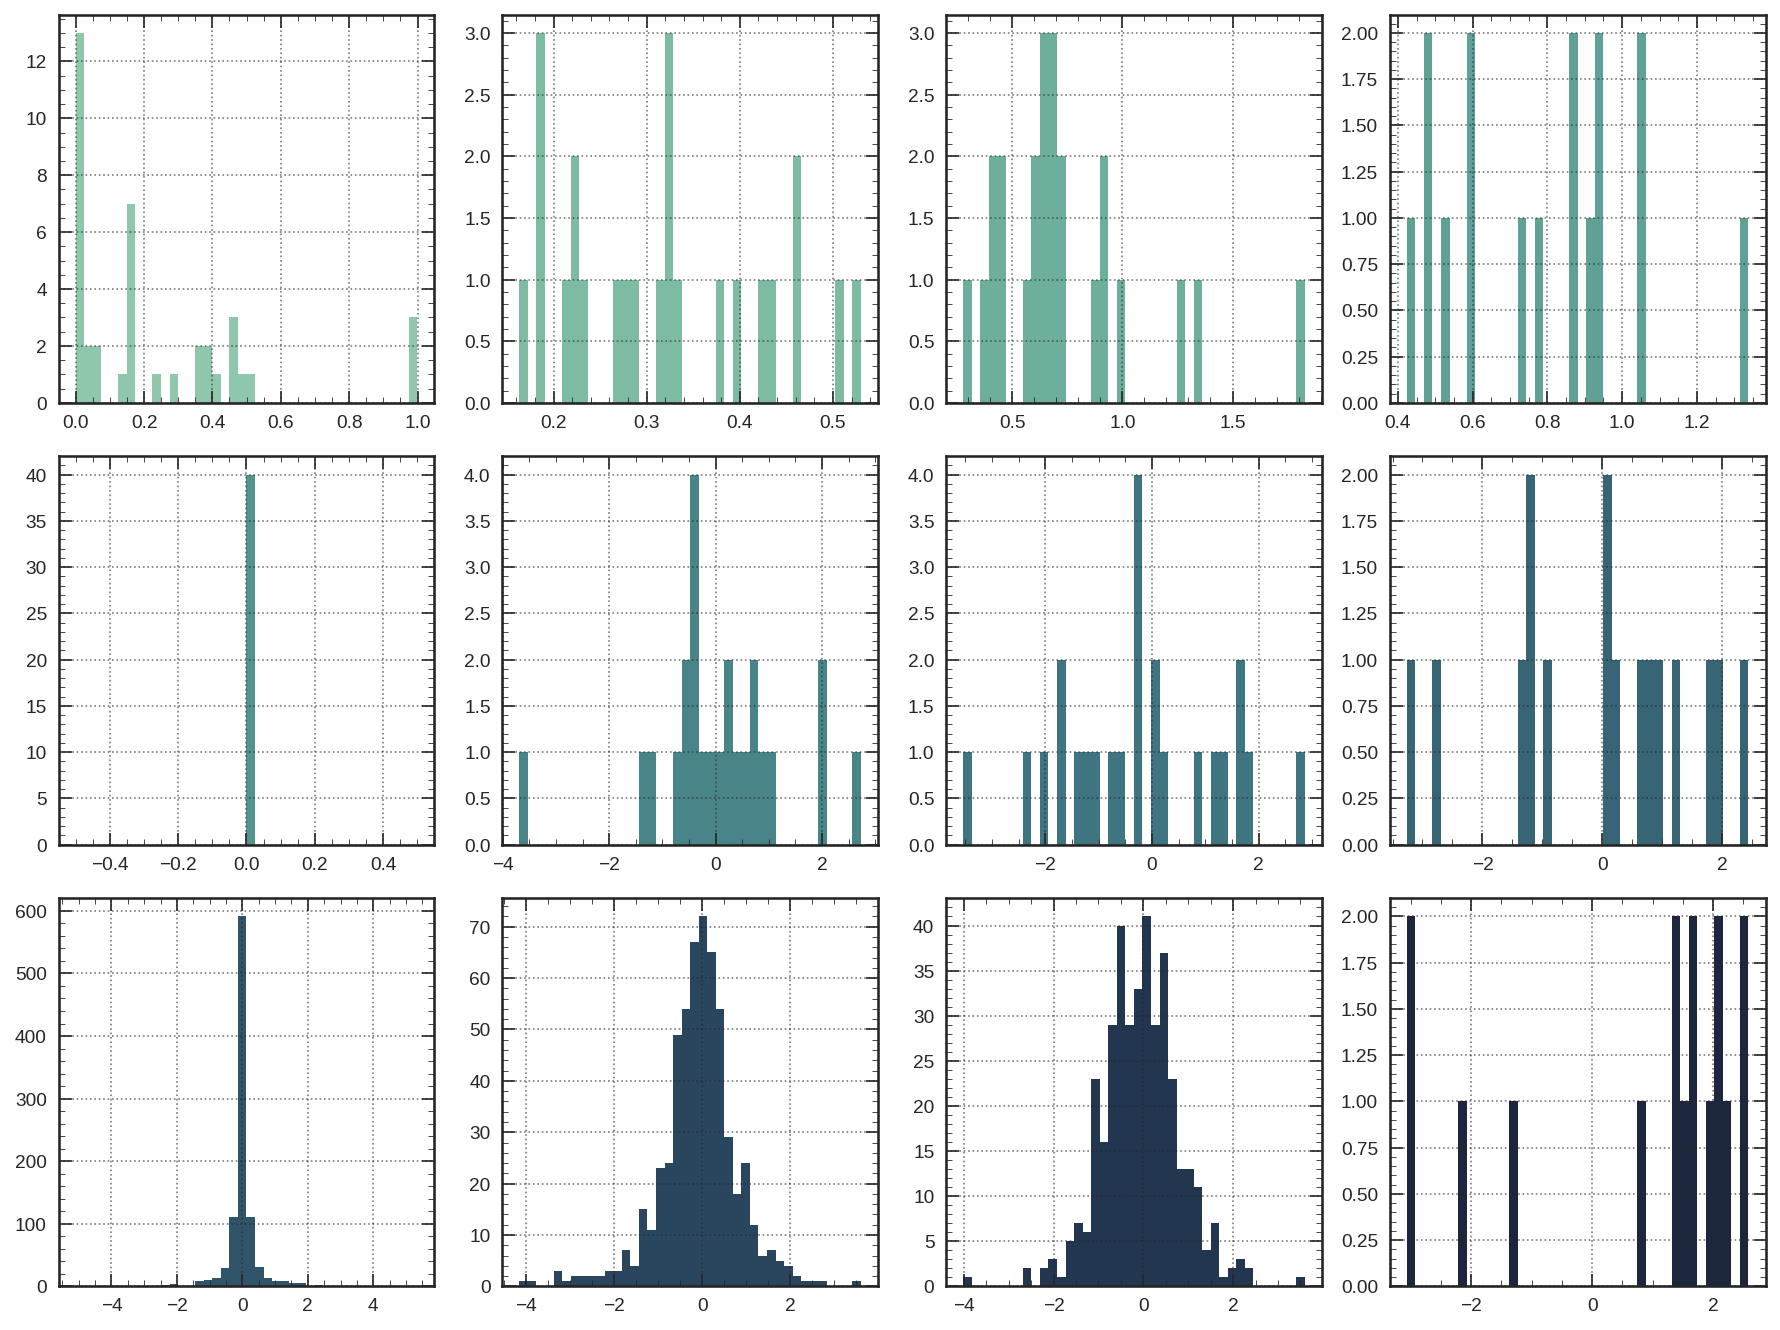

In [29]:
# Inspect model weights
if do_quantization:
  def get_normalization_scale_and_offset(layer):
    scale = layer.scale.numpy()
    offset = layer.offset.numpy()
    return (scale, offset)

  def get_batchnorm_scale_and_offset(layer):
    scale = (layer.gamma / tf.sqrt(layer.moving_variance)).numpy()
    offset = (layer.beta - layer.moving_mean * (layer.gamma / tf.sqrt(layer.moving_variance))).numpy()
    return (scale, offset)

  def get_folded_kernel_scale_and_offset(kernel, layer):
    scale = (kernel * (layer.gamma / tf.sqrt(layer.moving_variance))).numpy()
    offset = (layer.beta - layer.moving_mean * (layer.gamma / tf.sqrt(layer.moving_variance))).numpy()
    return (scale, offset)

  fig, axs = plt.subplots(3, 4, figsize=(6*2,6/2*3), tight_layout=True)
  pal = sns.cubehelix_palette(12, rot=-.4, light=.7)

  xx = get_normalization_scale_and_offset(model.get_layer('quant_preprocessing').layer)[0]
  ax = axs[0,0]
  ax.hist(xx, bins=40, color=pal[0])
  logger.info('preprocessing (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('quant_dense').layer.batchnorm)[0]
  ax = axs[0,1]
  ax.hist(xx, bins=40, color=pal[1])
  logger.info('batch_normalization (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('quant_dense_1').layer.batchnorm)[0]
  ax = axs[0,2]
  ax.hist(xx, bins=40, color=pal[2])
  logger.info('batch_normalization_1 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('quant_dense_2').layer.batchnorm)[0]
  ax = axs[0,3]
  ax.hist(xx, bins=40, color=pal[3])
  logger.info('batch_normalization_2 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  xx = get_normalization_scale_and_offset(model.get_layer('quant_preprocessing').layer)[1]
  ax = axs[1,0]
  ax.hist(xx, bins=40, color=pal[4])
  logger.info('preprocessing (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('quant_dense').layer.batchnorm)[1]
  ax = axs[1,1]
  ax.hist(xx, bins=40, color=pal[5])
  logger.info('batch_normalization (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('quant_dense_1').layer.batchnorm)[1]
  ax = axs[1,2]
  ax.hist(xx, bins=40, color=pal[6])
  logger.info('batch_normalization_1 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('quant_dense_2').layer.batchnorm)[1]
  ax = axs[1,3]
  ax.hist(xx, bins=40, color=pal[7])
  logger.info('batch_normalization_2 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  xx = model.get_layer('quant_dense').layer.folded_kernel.numpy()
  ax = axs[2,0]
  ax.hist(xx.reshape(-1), bins=40, color=pal[8])
  logger.info('dense (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = model.get_layer('quant_dense_1').layer.folded_kernel.numpy()
  ax = axs[2,1]
  ax.hist(xx.reshape(-1), bins=40, color=pal[9])
  logger.info('dense_1 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = model.get_layer('quant_dense_2').layer.folded_kernel.numpy()
  ax = axs[2,2]
  ax.hist(xx.reshape(-1), bins=40, color=pal[10])
  logger.info('dense_2 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = model.get_layer('quant_dense_final').layer.folded_kernel.numpy()
  ax = axs[2,3]
  ax.hist(xx.reshape(-1), bins=40, color=pal[11])
  logger.info('dense_final (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  plt.show()